In [ ]:
# ===============================================
#   YAMNet Transfer Learning (Per-Frame Embeddings)
#   Classes automatically extracted from folder names
# ===============================================

# author: Natalia Guevara

In [2]:
!pip install librosa tensorflow_hub pydub tqdm

In [60]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
# ======================================================
# 1. Load YAMNet from TF-Hub
# ======================================================
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

def extract_embeddings(wav_data, sr=16000):
    """Return (scores, embeddings, spectrogram) from YAMNet."""
    waveform = wav_data.astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return scores.numpy(), embeddings.numpy(), spectrogram.numpy()

In [3]:
# ======================================================
# 2. Create dataset with per frame embeddings
# ======================================================
def create_dataset(data_dir):
    X = []
    Y = []

    class_names = sorted([
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith(".")])


    print("Detected classes:", class_names)

    for cls in class_names:
        class_dir = os.path.join(data_dir, cls)
        audio_files = [f for f in os.listdir(class_dir) if f.lower().endswith(".wav")]

        print(f"\nProcessing class '{cls}' ({len(audio_files)} audio files)")

        for f in tqdm(audio_files):
            path = os.path.join(class_dir, f)

            wav, sr = librosa.load(path, sr=16000)
            _, embeddings, _ = extract_embeddings(wav)

            # embeddings.shape = (num_frames, 1024)
            for frame in embeddings:
                X.append(frame)
                Y.append(cls)

    X = np.array(X)
    Y = np.array(Y)
    print(f"\nTotal frames collected: {len(X)}")
    return X, Y, class_names

In [4]:
# ======================================================
# 3. Load dataset
# ======================================================
DATA_DIR = "C:\\Users\\guevarn\\BengalDetection\\tiger_data"
X, Y, class_names = create_dataset(DATA_DIR)

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(Y)
y_cat = to_categorical(y_enc)

# Save encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

Detected classes: ['noise', 'tiger_call', 'tiger_roar']

Processing class 'noise' (8 audio files)


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]



Processing class 'tiger_call' (6 audio files)


100%|██████████| 6/6 [00:00<00:00, 22.49it/s]



Processing class 'tiger_roar' (46 audio files)


100%|██████████| 46/46 [00:01<00:00, 23.16it/s]


Total frames collected: 196


In [5]:
# ======================================================
# 4. Train/test split
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, shuffle=True
)

In [6]:
# ======================================================
# 5. Classifier Model
# ======================================================
input_layer = Input(shape=(1024,))
x = Dense(512, activation="relu")(input_layer)
x = Dense(256, activation="relu")(x)
output_layer = Dense(len(class_names), activation="softmax")(x)

classifier = Model(input_layer, output_layer)
classifier.compile(optimizer="adam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,899 (2.51 MB)

 Trainable params: 656,899 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ======================================================
# 6. Train
# ======================================================
history = classifier.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    shuffle=True
)

classifier.save("classifier.h5")

print("\nTraining complete! Saved:")
print(" - classifier.h5")
print(" - label_encoder.pkl")


# ======================================================
# 7. Inference pipeline
# ======================================================
def predict_audio(wav_path):
    """Full inference: wav -> YAMNet -> frame predictions -> majority vote."""
    wav, sr = librosa.load(wav_path, sr=16000)
    _, embeddings, _ = extract_embeddings(wav)

    preds = classifier.predict(embeddings, verbose=0)  # per-frame predictions
    avg = np.mean(preds, axis=0)                       # average softmax
    cls_id = np.argmax(avg)
    label = encoder.inverse_transform([cls_id])[0]
    return label, avg

print("\nReady! Use predict_audio('/path/file.wav')")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6795 - loss: 0.8182 - val_accuracy: 0.8500 - val_loss: 0.4022
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8846 - loss: 0.2901 - val_accuracy: 0.9750 - val_loss: 0.1490
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9615 - loss: 0.1289 - val_accuracy: 0.9750 - val_loss: 0.0788
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9615 - loss: 0.0859 - val_accuracy: 1.0000 - val_loss: 0.0495
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9808 - loss: 0.0623 - val_accuracy: 1.0000 - val_loss: 0.0352
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9872 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 0.0352
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9936 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.0389
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9936 - loss: 0.0248 - val_accuracy: 1.0000 - val_loss: 0.0313


Training complete! Saved:
 - classifier.h5
 - label_encoder.pkl

Ready! Use predict_audio('/path/file.wav')


In [8]:
predict_audio('Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230315_070000.wav')

(np.str_('noise'),
 array([8.8856339e-01, 1.1117886e-01, 2.5764602e-04], dtype=float32))

# Load the saved model and encoder

In [61]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

In [62]:
from tensorflow.keras.models import load_model

classifier = load_model("classifier.h5")
classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,901 (2.51 MB)

 Trainable params: 656,899 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [63]:
import pickle

with open("label_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)

In [17]:
import os

def plot_yamnet_like(wav_path):
    """
    Recreates the original 3-panel YAMNet visualization:
      1. Waveform
      2. Log-mel spectrogram (from YAMNet)
      3. Per-frame custom-classifier scores (top-N), Y-axis = class names
    """

    # -------- NEW: extract file title --------
    base_name = os.path.basename(wav_path)
    title = os.path.splitext(base_name)[0]   # S4A17646_20230315_070000

    # Load audio
    waveform, sr = librosa.load(wav_path, sr=16000)
    waveform = waveform.astype(np.float32)

    # Run through YAMNet to get scores, embeddings, spectrogram
    scores, embeddings, spectrogram = yamnet_model(waveform)
    scores = scores.numpy()
    spectrogram = spectrogram.numpy()

    # Run your classifier (per-frame)
    preds = classifier.predict(embeddings.numpy(), verbose=0)

    class_names = list(encoder.classes_)

    # Mean score per class
    mean_scores = np.mean(preds, axis=0)

    # Top-N classes
    top_N = min(10, len(class_names))
    top_class_indices = np.argsort(mean_scores)[::-1][:top_N]

    # -----------------------------------------
    # PLOTTING
    # -----------------------------------------
    plt.figure(figsize=(12, 10))

    # NEW: Global title
    plt.suptitle(title, fontsize=16, y=1.02)

    # -----------------------------------------
    # 1. WAVEFORM
    # -----------------------------------------
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])
    plt.title("Waveform")
    plt.ylabel("Amplitude")

    # -----------------------------------------
    # 2. LOG-MEL SPECTROGRAM
    # -----------------------------------------
    plt.subplot(3, 1, 2)
    plt.imshow(
        spectrogram.T,
        aspect='auto',
        interpolation='nearest',
        origin='lower'
    )
    plt.title("Log-Mel Spectrogram")
    plt.ylabel("Mel Frequency Bin")

    # -----------------------------------------
    # 3. PER-FRAME CLASSIFIER SCORES
    # -----------------------------------------
    plt.subplot(3, 1, 3)
    im = plt.imshow(
        preds[:, top_class_indices].T,
        aspect='auto',
        interpolation='nearest',
        origin='lower',
        cmap='gray_r'
    )

    plt.title("Top Class Probabilities (Per-frame)")
    plt.xlabel("Frame")
    plt.yticks(range(top_N), [class_names[i] for i in top_class_indices])
    plt.ylabel("Class")

    cbar = plt.colorbar(im)
    cbar.set_label("Probability (0–1.0)")

    # Match original YAMNet alignment
    patch_window_seconds = 0.96
    patch_hop_seconds = 0.48
    patch_padding = (patch_window_seconds / 2) / patch_hop_seconds
    plt.xlim([-patch_padding, preds.shape[0] + patch_padding])

    plt.tight_layout()
    plt.show()

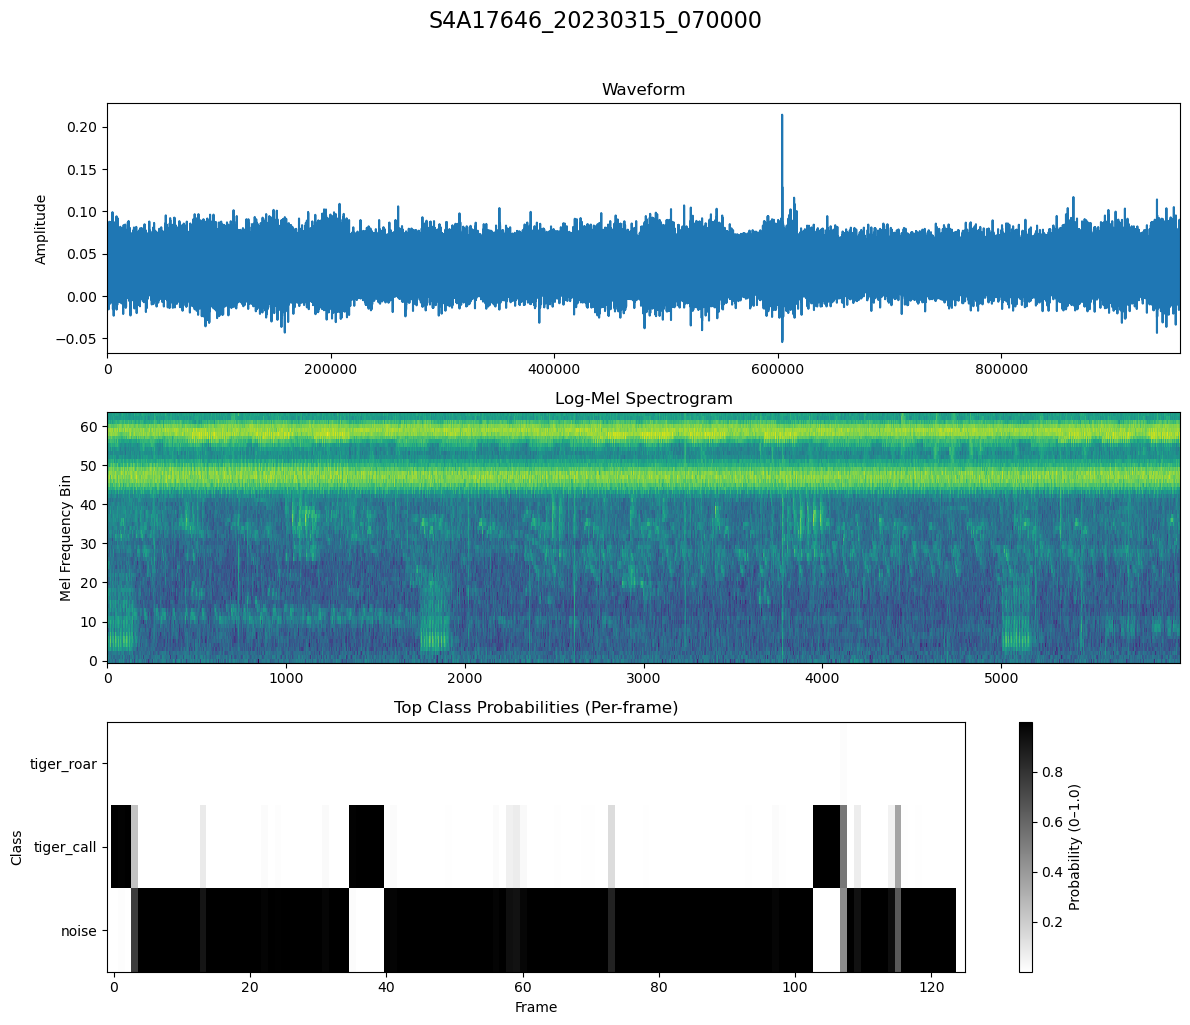

In [18]:
plot_yamnet_like("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230315_070000.wav")

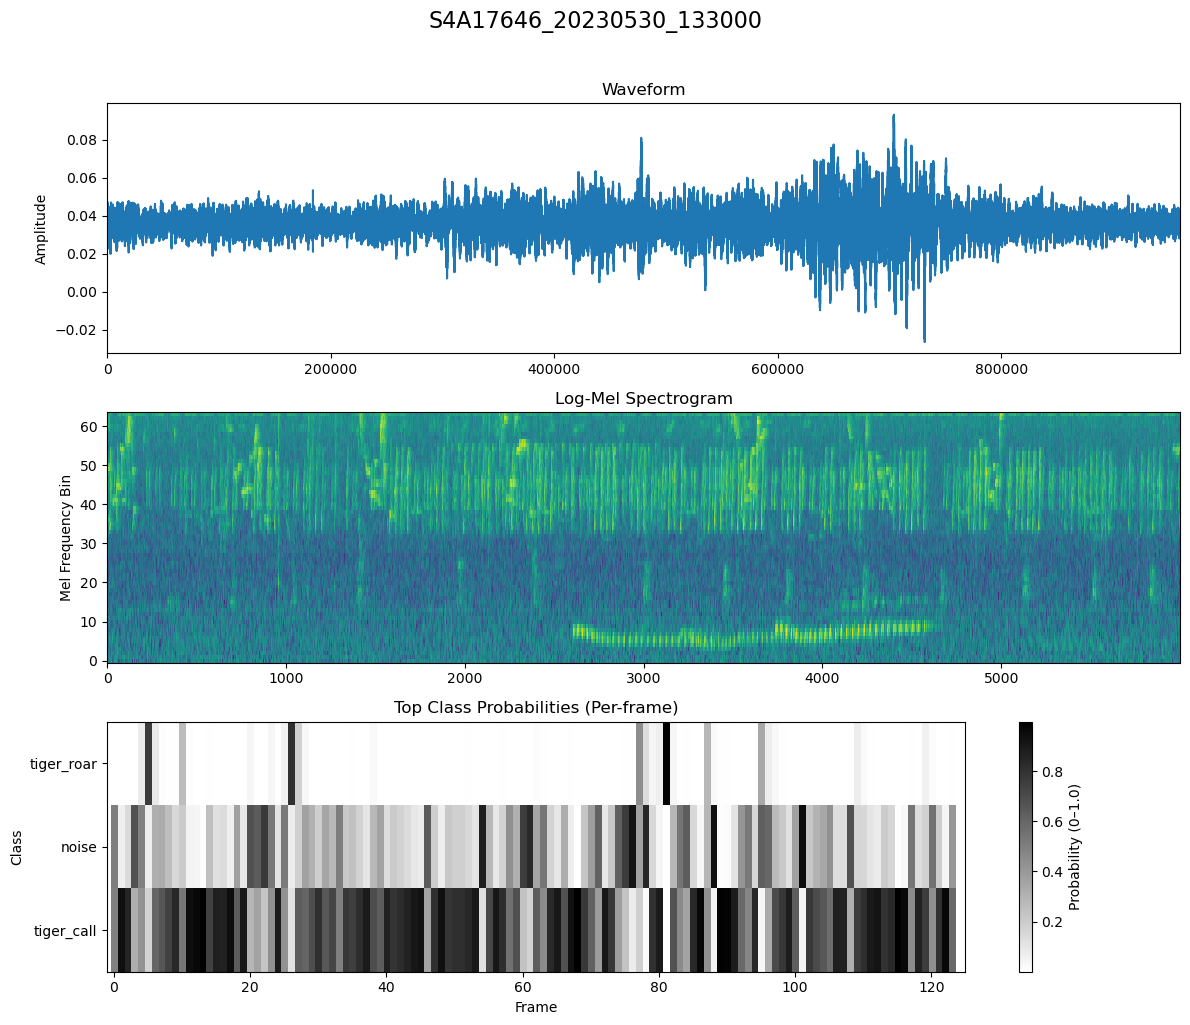

In [35]:
plot_yamnet_like("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230530_133000.wav")

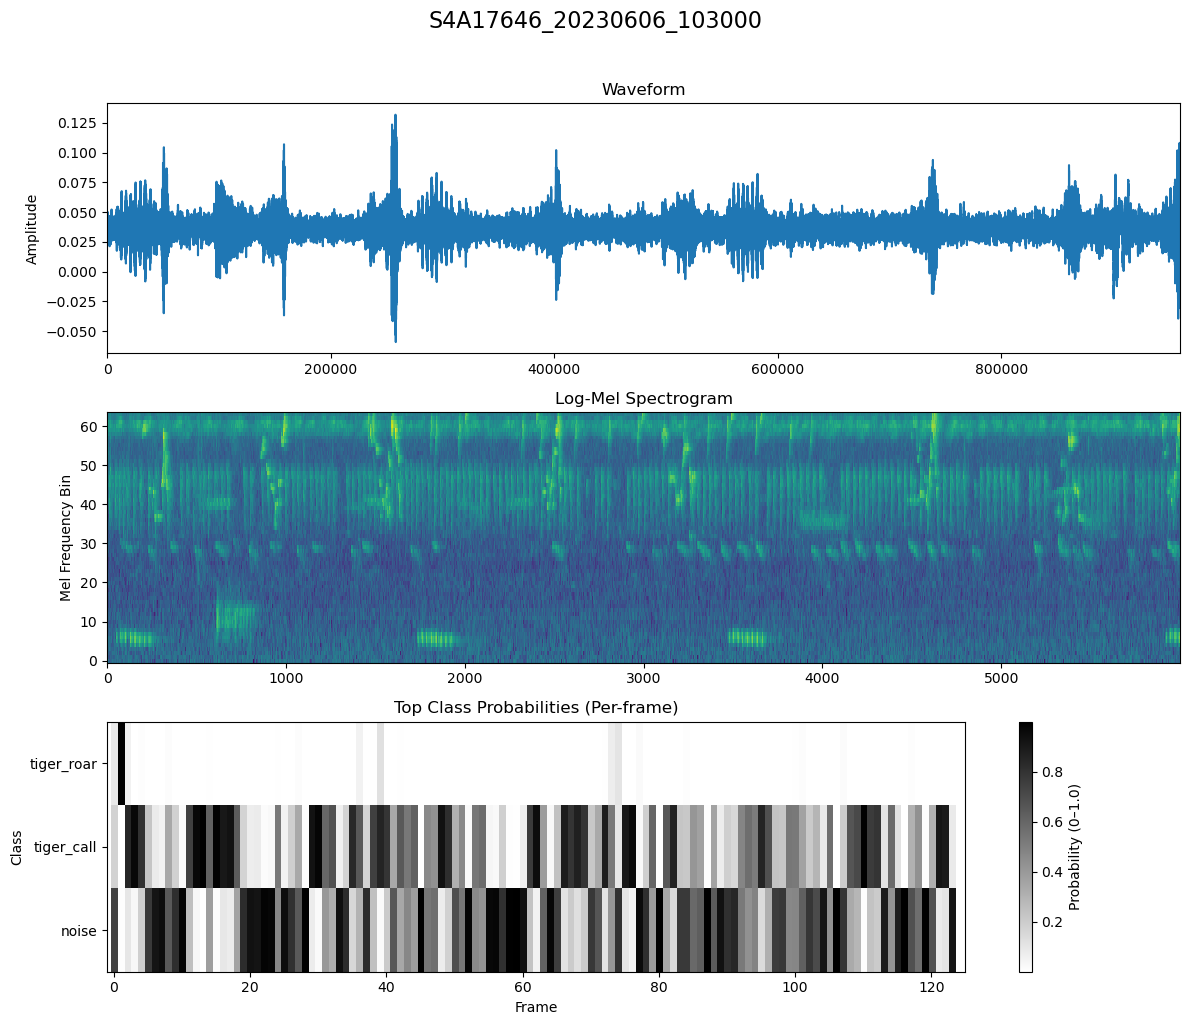

In [45]:
plot_yamnet_like("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230606_103000.wav")

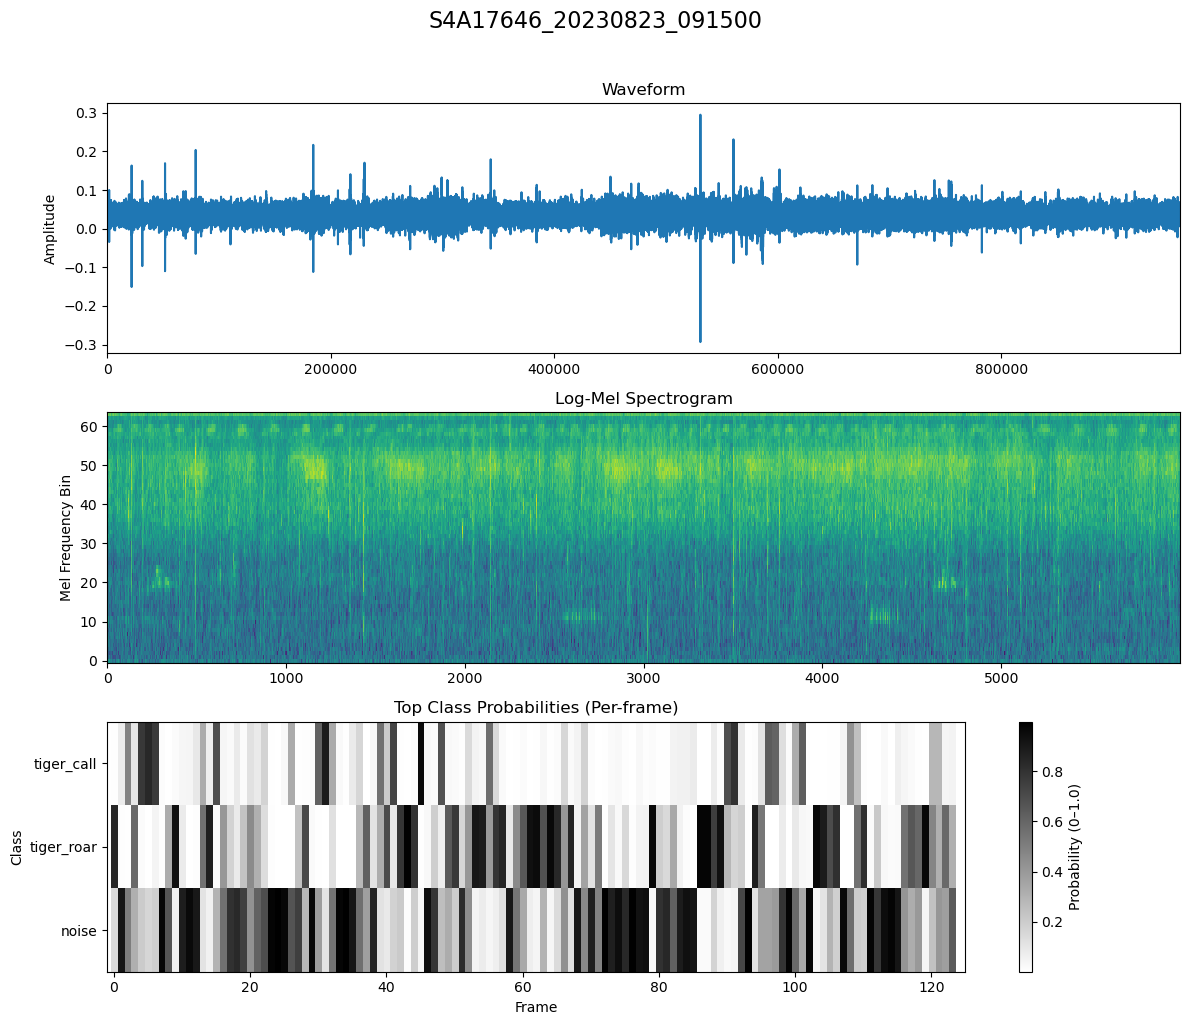

In [44]:
plot_yamnet_like("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230823_091500.wav")

# Finding more cases

In [13]:
import pandas as pd

In [54]:
# -------------------------
# CONFIG PARAMETERS
# -------------------------
AUDIO_DIR = "Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data"  # change this
OUTPUT_CSV = "tiger_detection_results3.csv"

# classification params
FRAME_THRESHOLD = 0.4     # probability threshold per frame
FILE_THRESHOLD = 0.05     # % of frames above threshold to call file "tiger"
TOP_CLASSES_ONLY = ["tiger_roar", "tiger_call"]  # target classes

In [55]:
def analyze_audio_file(path):
    wav, sr = librosa.load(path, sr=16000)
    wav = wav.astype(np.float32)

    # YAMNet embeddings
    _, embeddings, _ = yamnet_model(wav)

    # Per-frame predictions
    preds = classifier.predict(embeddings.numpy(), verbose=0)
    class_names = encoder.classes_

    # Extract target probabilities (sum roar + call)
    tiger_probs = np.zeros(len(preds))
    for i, cls in enumerate(class_names):
        if cls in TOP_CLASSES_ONLY:
            tiger_probs += preds[:, i]

    tiger_probs = tiger_probs / len(TOP_CLASSES_ONLY)  # normalize

    # Metrics
    max_prob = float(tiger_probs.max())
    pct_frames_over = float(np.mean(tiger_probs > FRAME_THRESHOLD))

    # Final decision
    has_tiger = pct_frames_over >= FILE_THRESHOLD

    return {
        "path": path,
        "max_prob": max_prob,
        "pct_frames_over": pct_frames_over,
        "has_tiger": has_tiger
    }

In [56]:
analyze_audio_file("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230315_070000.wav")

{'path': 'Z:\\data\\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230315_070000.wav',
 'max_prob': 0.4999844475387363,
 'pct_frames_over': 0.0967741935483871,
 'has_tiger': True}

In [57]:
from tqdm.auto import tqdm
import pandas as pd
import os

In [58]:
def analyze_directory(audio_dir, max_files=None):
    results = []
    wavs = [f for f in os.listdir(audio_dir) if f.lower().endswith(".wav")]

    print(f"Processing {len(wavs)} audio files...\n")

    # Limit number of files if requested
    if max_files is not None:
        wavs = wavs[2000:max_files]

    for f in tqdm(wavs):
        full_path = os.path.join(audio_dir, f)
        info = analyze_audio_file(full_path)
        results.append(info)

    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)

    print("\nDONE!")
    print(f"Saved results to: {OUTPUT_CSV}")
    print(df.head())
    return df

In [64]:
df = analyze_directory(AUDIO_DIR, 3000)

Processing 18072 audio files...



100%|██████████| 1000/1000 [38:33<00:00,  2.31s/it]


DONE!
Saved results to: tiger_detection_results3.csv
                                                path  max_prob  \
0  Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...  0.498739   
1  Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...  0.456024   
2  Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...  0.490615   
3  Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...  0.495849   
4  Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...  0.485281   

   pct_frames_over  has_tiger  
0         0.209677       True  
1         0.024194      False  
2         0.120968       True  
3         0.185484       True  
4         0.016129      False  


In [65]:
print("Total files:", len(df))
print("Tiger detected:", df["has_tiger"].sum())
print("Non-tiger:", len(df) - df["has_tiger"].sum())

df[df["has_tiger"] == True].head()

Total files: 1000
Tiger detected: 411
Non-tiger: 589


,path,max_prob,pct_frames_over,has_tiger
0,Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...,0.498739,0.209677,True
2,Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...,0.490615,0.120968,True
3,Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...,0.495849,0.185484,True
5,Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...,0.495087,0.064516,True
6,Z:\data\Bangladesh\Sundarbans_2023\Sensors_rec...,0.486159,0.072581,True


In [ ]:
list(df[df["has_tiger"] == True]["path"])

In [ ]:
#df = pd.read_csv("tiger_detection_results2.csv")
df2 = df[df["has_tiger"] == True].sort_values("max_prob", ascending=False)
for path in df2["path"].tolist():
    plot_yamnet_like(path)

In [ ]:
for i in list(df[df["has_tiger"] == True]["path"]):
    plot_yamnet_like(i)

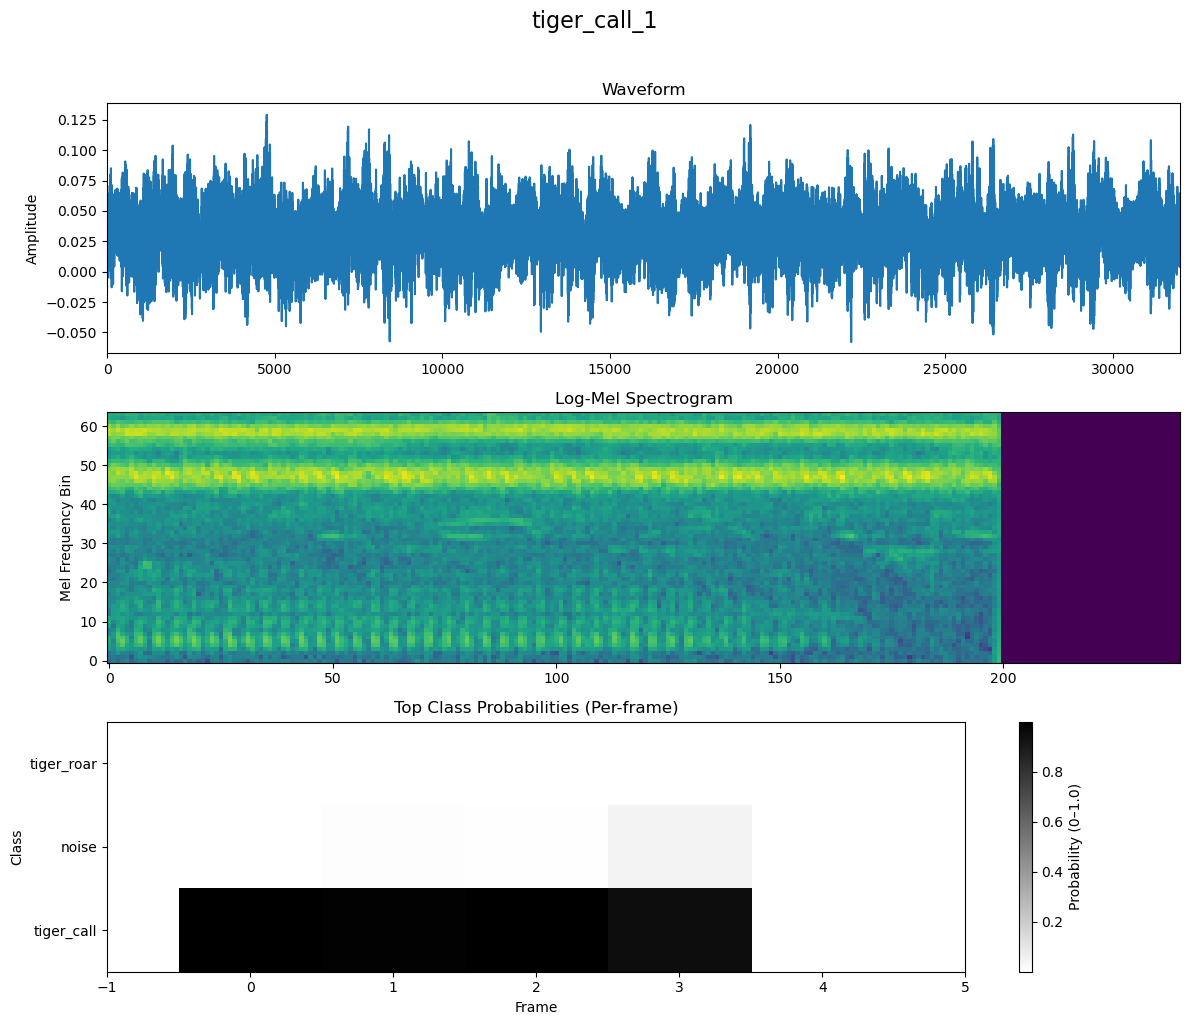

In [49]:
plot_yamnet_like("C:\\Users\\guevarn\\BengalDetection\\tiger_data\\tiger_call\\tiger_call_1.wav")

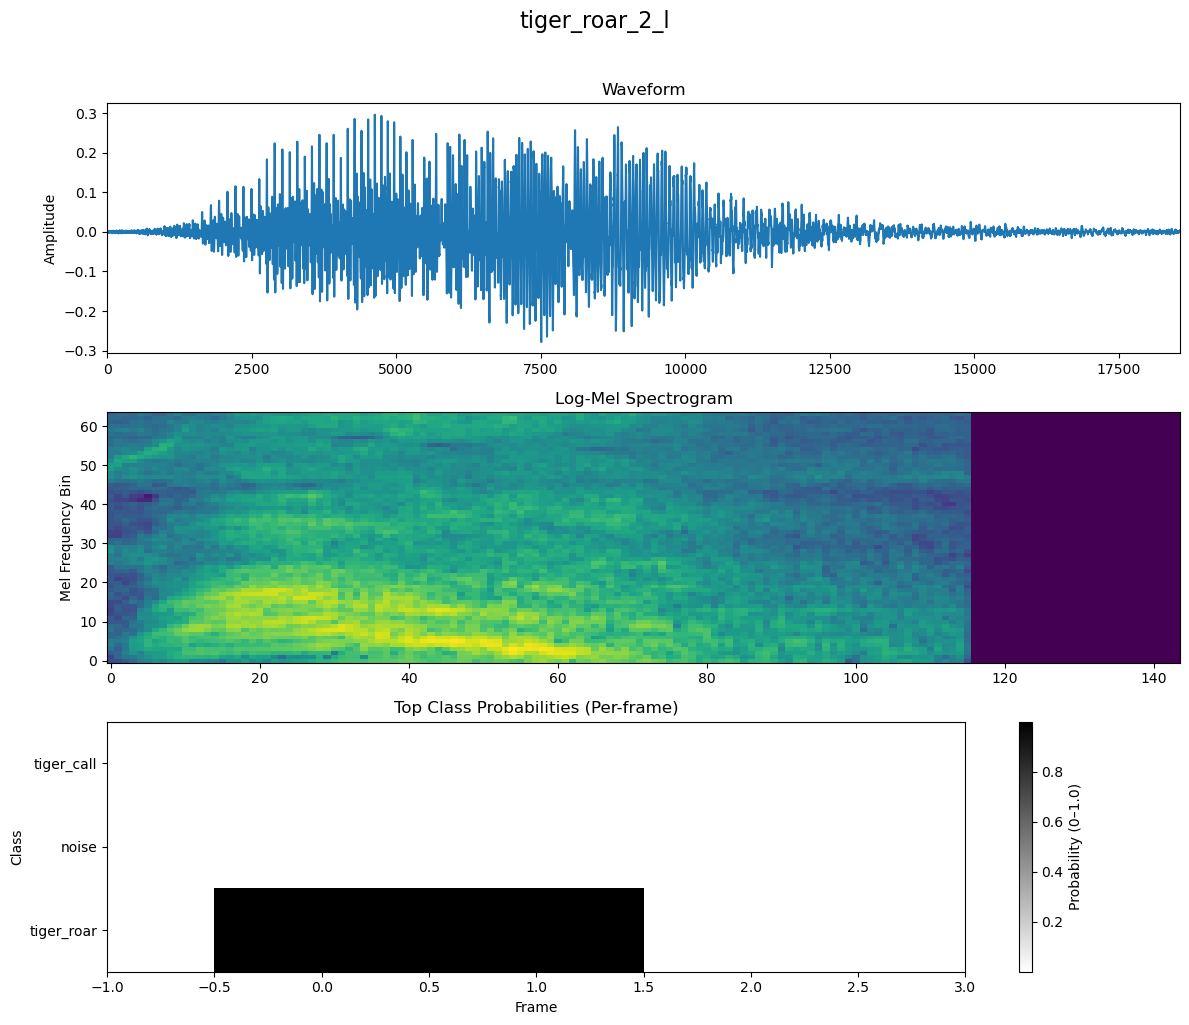

In [50]:
plot_yamnet_like("C:\\Users\\guevarn\\BengalDetection\\tiger_data\\tiger_roar\\tiger_roar_2_l.wav")

In [ ]:
## RUN 2 AUDIOS

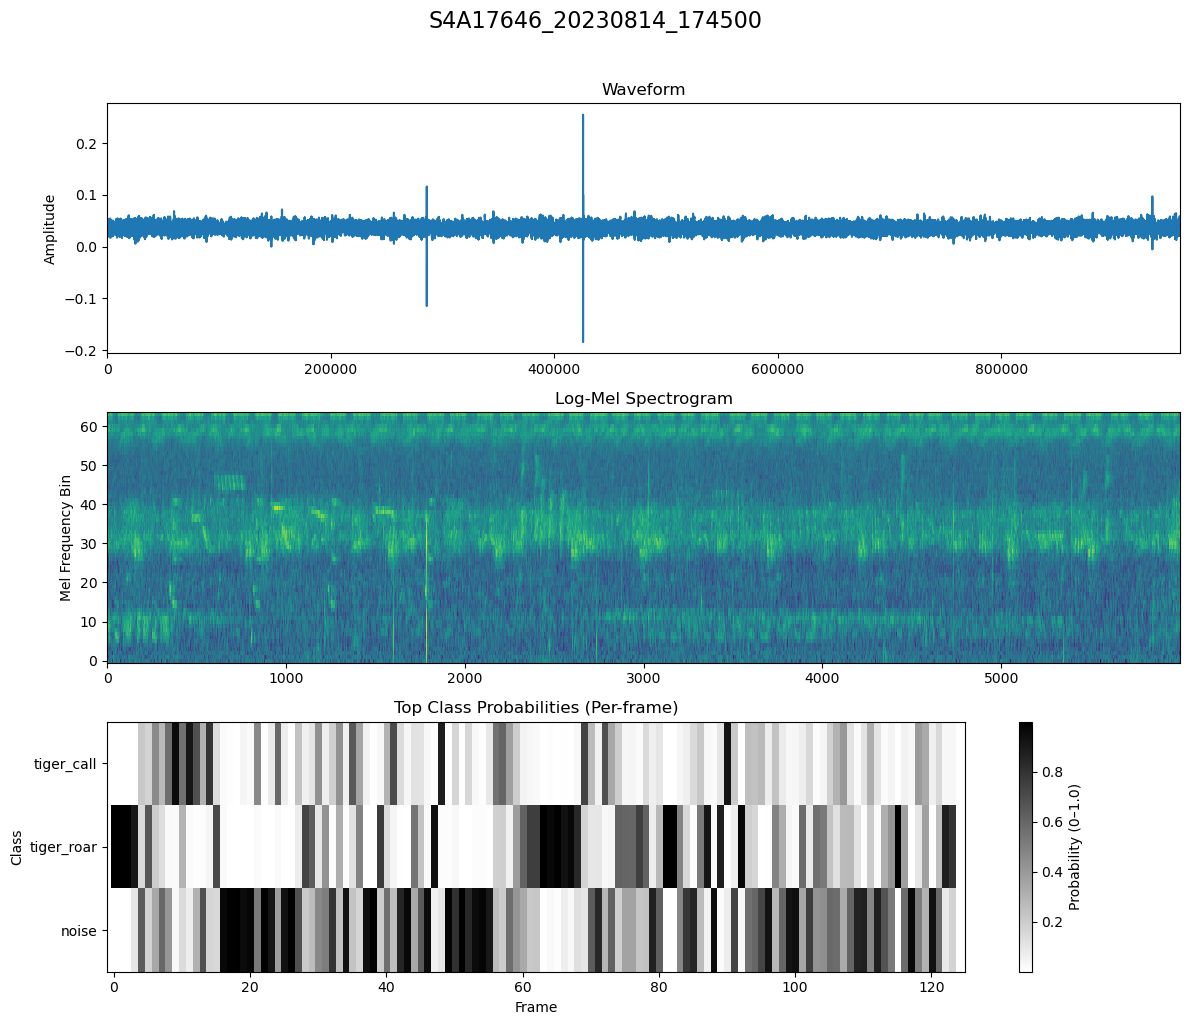

In [47]:
plot_yamnet_like("Z:\\data\Bangladesh\\Sundarbans_2023\\Sensors_recording\\December\\033_S4A17646\\Data\\S4A17646_20230814_174500.wav")

In [51]:
len(df2["path"].tolist())

391